# 06 — Fine-Tuning IndoBERT untuk Analisis Sentimen Komentar YouTube

Notebook ini melakukan proses **fine-tuning IndoBERT** pada dataset komentar YouTube 
terkait isu korupsi proyek Whoosh.

Tahapan meliputi:

1. Load dataset yang sudah ditokenisasi (hasil notebook 05).
2. Load model IndoBERT pre-trained.
3. Konfigurasi TrainingArguments.
4. Training menggunakan HuggingFace Trainer.
5. Evaluasi model:
   - Accuracy
   - F1-Macro
   - Confusion Matrix
   - Classification Report
6. Menyimpan model untuk kebutuhan prediksi lanjutan.

Model baseline sebelumnya yaitu TF-IDF, sehingga model IndoBERT pada notebook ini
akan dibandingkan untuk menunjukkan peningkatan performa.


----

## Import Library

In [31]:
# !pip install --upgrade transformers datasets accelerate
from datasets import load_from_disk
from transformers import AutoModelForSequenceClassification, Trainer
from transformers import TrainingArguments
from transformers import AutoTokenizer
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

## Load Dataset Tokenized dari Notebook 05

In [12]:
tokenized_ds = load_from_disk("../data/indobert_tokenized/")
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 789
    })
    validation: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 99
    })
    test: Dataset({
        features: ['labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 99
    })
})

## Load Model IndoBERT Pretrained

In [13]:
model_name = "indobenchmark/indobert-base-p2"

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,                     # negative, neutral, positive
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


c:\Users\hafizh\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:798: UserWarning: Not enough free disk space to download the file. The expected file size is: 497.79 MB. The target location C:\Users\hafizh\.cache\huggingface\hub\models--indobenchmark--indobert-base-p2\blobs only has 8.33 MB free disk space.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


## Metrics Function (Accuracy + F1 Macro)

In [14]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "f1_macro": f1_macro
    }

## Training Arguments

In [18]:
training_args = TrainingArguments(
    output_dir="../models/indobert_finetuned",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_steps=100,      # berapa sering log
    save_total_limit=1,     # maksimal checkpoint disimpan
)

## Trainer IndoBERT

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    compute_metrics=compute_metrics,
)

## Train IndoBERT

In [20]:
trainer.train()

c:\Users\hafizh\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,0.689600
200,0.457500
300,0.250200


TrainOutput(global_step=396, training_loss=0.39157627086446745, metrics={'train_runtime': 1047.247, 'train_samples_per_second': 3.014, 'train_steps_per_second': 0.378, 'total_flos': 207596486587392.0, 'train_loss': 0.39157627086446745, 'epoch': 4.0})

## Evaluasi Pada Test Set

In [21]:
pred = trainer.predict(tokenized_ds["test"])
pred

c:\Users\hafizh\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


PredictionOutput(predictions=array([[-0.3678759 ,  2.522617  , -2.3442886 ],
       [ 3.935758  , -1.9500912 , -2.0624464 ],
       [ 4.0050254 , -3.138707  , -1.4870301 ],
       [ 2.778314  , -1.9050555 , -1.0893934 ],
       [-0.3068203 ,  0.6859207 , -0.10164951],
       [ 3.245498  , -1.6214143 , -1.8620534 ],
       [ 3.0280957 , -1.613415  , -2.1420734 ],
       [ 3.711489  , -2.1294806 , -2.0428429 ],
       [ 4.208532  , -2.7631078 , -1.5035157 ],
       [ 2.9399848 , -1.39192   , -2.3549583 ],
       [ 2.557064  , -1.0264364 , -1.4800236 ],
       [ 3.4843376 , -1.9554223 , -2.2719858 ],
       [ 3.6780605 , -2.3569481 , -1.8998032 ],
       [ 2.723079  , -1.6787556 , -1.2570534 ],
       [ 4.0293694 , -2.7296414 , -1.9807954 ],
       [ 0.2099522 ,  1.4283084 , -1.8016489 ],
       [-0.99829346,  2.437802  , -1.1746273 ],
       [-2.7125812 ,  4.145156  , -1.462714  ],
       [ 4.2373886 , -2.9233549 , -1.9611486 ],
       [ 3.725999  , -2.1410797 , -2.574693  ],
       [ 2.

In [22]:
logits = pred.predictions
y_pred = np.argmax(logits, axis=1)
y_true = pred.label_ids

## Print Evaluation Metrics

In [23]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Macro:", f1_score(y_true, y_pred, average="macro"))

Accuracy: 0.6565656565656566
F1 Macro: 0.4012345679012346


## Classification Report

In [24]:
target_names = ["negative", "neutral", "positive"]

print(classification_report(
    y_true,
    y_pred,
    target_names=target_names
))

              precision    recall  f1-score   support

    negative       0.74      0.80      0.77        65
     neutral       0.45      0.42      0.43        31
    positive       0.00      0.00      0.00         3

    accuracy                           0.66        99
   macro avg       0.40      0.41      0.40        99
weighted avg       0.63      0.66      0.64        99



c:\Users\hafizh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\hafizh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\hafizh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

## Confusion Matrix

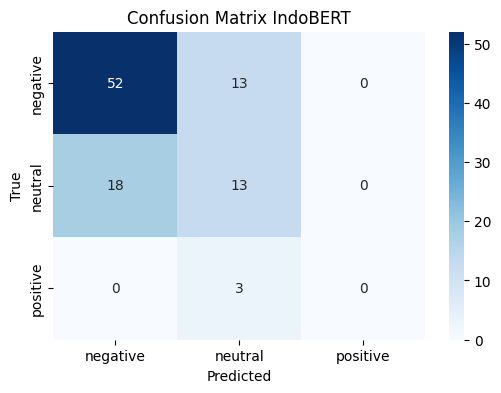

In [26]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix IndoBERT")
plt.show()

## Save Final Model

In [33]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

In [34]:
save_dir = "../models/indobert_sentiment_final"
trainer.save_model(save_dir)          # save model
tokenizer.save_pretrained(save_dir)   # save tokenizer juga

('../models/indobert_sentiment_final\\tokenizer_config.json',
 '../models/indobert_sentiment_final\\special_tokens_map.json',
 '../models/indobert_sentiment_final\\vocab.txt',
 '../models/indobert_sentiment_final\\added_tokens.json',
 '../models/indobert_sentiment_final\\tokenizer.json')